### Code used for Chapter 7: Comparisons. 1D DFT.

Import libraries.

The detect_peaks.py is from:
https://github.com/demotu/BMC/blob/master/functions/detect_peaks.py

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy import integrate
import time
import pyfftw
from numba import jit
from detect_peaks import detect_peaks
%matplotlib inline

In chapter 4, section 4.3, it was found that the order of convergence of the 2D strong-stability preserving 3rd-order Runge-Kutta with 4th-order central difference scheme does not actually preserve the intended order of convergence.

Here, a 1D strong-stability preserving 2nd-order Runge-Kutta time-stepping with 2nd-order accuracy central difference scheme is used. This is for reasons of computational cost and since the order of convergence is limited to first-order in space anyway.

For more details on the strong-stability preserving Runge-Kutta methods, see [Gottlieb et. al](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.29.497&rep=rep1&type=pdf).

The shift/roll algorithm is used here (see 2D_Strang_SSP_RK3.ipynb for more details on this algorithm).

In [5]:
import os
import sys
import h5py

class writer(object):
    
    def __init__(self,prefix,Lx,Ly,base_output_folder=None,suffix=None):
        self.prefix = prefix
        self.Lx = Lx
        self.Ly = Ly
        
        self.path = self.get_file_path(base_output_folder,suffix)

        self.groups = ['avg_conc', 'energy', 'order_parameter']
        
    def get_file_path(self, base_output_folder=None,suffix=None):
        if base_output_folder == None:
#             os.chdir(os.path.dirname(sys.argv[0]))
            os.chdir('/home/ray/git-projects/modified_ch/')
            base_output_folder = "output"
        if suffix != None:
            base_output_folder += "/" + suffix
        base_output_folder += "/"
        base_output_name = "%s_Lx=%.4f_Ly=%.4f" %(self.prefix,self.Lx,self.Ly)
#         print(base_output_name)
        hdf5_format = '.h5'
        return base_output_folder + base_output_name + hdf5_format
        
        
    def create_output_file(self, options):
#         print(self.path)
#         print(os.getcwd())

        if os.path.exists(self.path):
            os.rename(self.path, self.path+'_old')

        file = h5py.File(self.path, 'a')

        for group in self.groups:
            # check if groups have been created
            # if not created, create empty groups
            if not (group in file):
                file.create_group(group,track_order=True)

        for key in options:
            if type(options[key]) != str:
                file.attrs.create(key,options[key])
        file.close()
        
    def write_data(self, it, data):
        file = h5py.File(self.path , 'r+')
        
        for group, datum in zip(self.groups,data):
            name = group + '_%i' %it
            if isinstance(datum, (list, tuple, np.ndarray)):
                file.create_dataset(group + '/' + name, data=datum ,chunks=True, compression='gzip', compression_opts=4, dtype=np.float64)
            else:
                file.create_dataset(group + '/' + name, data=datum , dtype=np.float32)
        # print("writing time = %.1f for arrays %s" %(name,path))
        file.close()
        
    def get_dataset(self,group,it):
        file = h5py.File(self.path, 'r')
        
        arr = np.copy(file[group][group + '_' + str(it)])
        
        file.close()
        return arr

In [6]:
@jit(nopython=True)
def shifty(A,num):
    E = np.empty_like(A)
    F = np.empty_like(A)
    
    E[:num] = A[-num:]
    E[num:] = A[:-num]
    F[:-num] = A[num:]
    F[-num:] = A[:num]

    return E + F

@jit(nopython=True)
def shiftx(A,num):
    G = np.empty_like(A)
    H = np.empty_like(A)
    
    G[:,:num] = A[:,-num:]
    G[:,num:] = A[:,:-num]
    H[:,:-num] = A[:,num:]
    H[:,-num:] = A[:,:num]
    return G + H

@jit(nopython=True)
def centralDiff(A,hx,hy,delta):
    A = A**3
#     D = -1.*shift(A,2)+ 16.*shift(A,1) - 60.*A
    Dx = -1. * shiftx(A,2) + 16. * shiftx(A,1) - 30.*A
    Dx /= 12.*hx**2
    Dy = -1. * shifty(A,2) + 16. * shifty(A,1) - 30.*A
    Dy /= 12.*hy**2
    return 1./delta * (Dx+Dy)

@jit(nopython=True)
def ssp_rk2(v,hx,hy,dt,delta,m):
    v1 = v + dt * (centralDiff(v,hx,hy,delta) + m)
    v = 1./2. * v + 1./2. * v1 + 1./2. * dt * (centralDiff(v1,hx,hy,delta) + m)
    return v

def ic_hex(Nx,Ny):
    arr = np.ones((Ny,Nx)) * -0.0
    mi = 3
    mi += 0
    eix = 6
    eix += 1
    eiy = 1
    eiy += 0
    bs = 19
    br = int(bs/2)
#     print(br)

    bidx0 = (slice(0,br),slice(eix,eix+bs))
    bidx1 = (slice(-br,None),slice(eix,eix+bs))

    bidx2 = (slice(0,br),slice(-eix-bs,-eix))
    bidx3 = (slice(-br,None),slice(-eix-bs,-eix))

    bidx4 = (slice(eiy+bs+mi,eiy+mi+2*bs),slice(-br,None))
    bidx5 = (slice(eiy+bs+mi,eiy+mi+2*bs),slice(0,br))
    bidx6 = (slice(eiy+bs+mi,eiy+mi+2*bs),slice(int(Nx/2) - br,int(Nx/2) + br+1))

    ball = np.ones((19,19)) * -0.0
    xx = np.arange(-9,10)
    X,Y = np.meshgrid(xx,xx)
    r = np.sqrt(X**2 + Y**2)
#     print(r)
    ball[np.where(r <= 9.)] = 1.0
    ball_left = ball[:,:br]
    ball_right = ball[:,br+1:]
    ball_top = ball[:br,:]
    ball_bottom = ball[br+1:,:]

    arr[bidx0] = ball_bottom * 0.1
    arr[bidx1] = ball_top * 0.1
    arr[bidx2] = ball_bottom * 0.1
    arr[bidx3] = ball_top * 0.1
    arr[bidx4] = ball_left * 0.1
    arr[bidx5] = ball_right * 0.1
    arr[bidx6] = ball
    return arr

The main DFT looping. This is the 1D algorithm based on the discussions of chapter 4, however instead of the Strang-splitting, a 1st-order Lie-splitting is used (again for computational speed and the fact that the order of convergence is reduced anyway).

See *appendix E: Splitting methods* for more details on the Strang- and Lie-splittings.

In [115]:
def dft(options,wisdom=None):
    Lx = options['Lx']
    Ly = options['Ly']
    Nx = options['Nx']
    Ny = options['Ny']
    delta = options['delta']
    m = options['m']
    dt = options['dt']
    it = options['it']
    prefix = options['prefix']
    
    io = writer(prefix,Lx,Ly)
    io.create_output_file(options)
    
    # h = spatial step-size; dx = 1D spatial grid.
    hx = Lx/Nx
    hy = Ly/Ny
    dx = np.linspace(0,Lx,Nx)
    dy = np.linspace(0,Ly,Ny)
    dxy = [dx,dy]

    # lv = levels to capture average concentration and energy changes.
    it += 1
    lv = int(it/100)

    # define empty arrays for pyFFTW
    u = pyfftw.empty_aligned((Nx,Ny), dtype='complex128', n=16)
    uhatx = pyfftw.empty_aligned((Nx,Ny), dtype='complex128', n=16)
    uhaty = pyfftw.empty_aligned((Nx,Ny), dtype='complex128', n=16)
    vx = pyfftw.empty_aligned((Nx,Ny), dtype='complex128', n=16)
    vy = pyfftw.empty_aligned((Nx,Ny), dtype='complex128', n=16)
    
    uhat = pyfftw.empty_aligned((Nx,Ny), dtype='complex128', n=16)
    v = pyfftw.empty_aligned((Nx,Ny), dtype='complex128', n=16)

    # a constant.
    tpiLx = 2.*np.pi/Lx
    tpiLy = 2.*np.pi/Ly

    # initial condition
    np.random.seed(555)
    C = 0.00001 # scaling factor
    r = np.random.uniform(-1.,1.,(Nx,Ny))

    # zeroing the mean of the uniform distribution.
    if r.mean()<0:
        r += r.mean()
    else:
        r -= r.mean()

    u[:,:] = m + C*r
    
#     file_ic = h5py.File('/home/ray/git-projects/modified_ch/ic_128_128.h5', 'r')
#     if Ly >= 11.1:
    file_ic = h5py.File('/home/ray/git-projects/modified_ch/ic_2periods.h5', 'r')
#     else:
#     file_ic = h5py.File('/home/ray/git-projects/modified_ch/ic_64_64.h5', 'r')
    file_ic = h5py.File('/home/ray/git-projects/modified_ch/ic_2periods_nospacing.h5', 'r')
    r = file_ic['ic'][:,:]
    u[:,:] = (m - 0.5 * r.mean()) + 0.5 * r
    
    print(u.real.mean())
    print("IC:")
    
    plt.figure()
    plt.imshow(u.real, extent=[0,Lx,0,Ly])
    plt.colorbar()
    plt.show()
    
#     assert(0)
#     u[:,:] = ic_hex(Nx,Ny)

#     xx, _ = np.meshgrid(dx,dx)
#     u[:,:] = C*np.cos(xx)
#     u[:,:] = u - u.mean()
        
    # generate wavenumber / frequency grid.
    freqX = np.fft.fftfreq(Nx,(1.0/float(Nx))) * tpiLy
    freqY = np.fft.fftfreq(Ny,(1.0/float(Ny))) * tpiLx
    kx, ky = np.meshgrid(freqY,freqX)
    k = kx + ky
    k2 = kx**2+ky**2
    kx2 = k2
    ky2 = k2
    kx4 = k2**2
    ky4 = k2**2

#     kx2 = kx**2
#     ky2 = ky**2
    
#     kx4 = kx**4
#     ky4 = ky**4
    
    k = np.sqrt(k2)

    # empty arrays to store avg. conc. and energy.
    avgConc = np.zeros(int(it/lv+1))
    energy = np.zeros(int(it/lv+1))

    # if there is pyFFTW wisdom, import it.
    if wisdom != None:
        pyfftw.import_wisdom(wisdom)

    # define pyFFTW plans.
    fft_x = pyfftw.FFTW(u, uhatx, threads=4, axes=(0,1))
#     ifft_x = pyfftw.FFTW(vx, uhatx, direction='FFTW_BACKWARD', threads=4, axes=(0,))
    
    fft_y = pyfftw.FFTW(u, uhaty, threads=4, axes=(1,))
#     ifft_y = pyfftw.FFTW(vy, uhaty, direction='FFTW_BACKWARD', threads=4, axes=(1,))

    ifft_obj = pyfftw.FFTW(v, uhatx, direction='FFTW_BACKWARD', threads=4, axes=(0,1))

    j = 0
    t1 = 0
    t2 = 0
    
    # iterations.
    for i in range(it+1):
        # the Fourier-PS substep.
        tic1 = time.time()
        fac=0.5
#         uhatx = np.exp((-1.*delta*(kx4*(fac*tpiLx)**4 + ky4*(fac*tpiLy)**4)+(1./delta)*(kx2*(fac*tpiLx)**2 + ky2*(fac*tpiLy)**2)-1.)*dt)*fft_x(u)
#         uhatx = np.exp((-1.*delta*(kx4*fac*(tpiLx)**4 + ky4*fac*(tpiLy)**4)+(1./delta)*(kx2*fac*(tpiLx)**2 + ky2*fac*(tpiLy)**2)-1.)*dt)*fft_x(u)
        uhatx = np.exp((-1.*delta*(kx4*fac + ky4*fac) + (1./delta)*(kx2*fac + ky2*fac) -1.)*dt)*fft_x(u)
#         uhatx = np.exp((-1.*delta*((k*fac*tpiLx + k*fac*tpiLy)**4)+(1./delta)*((k*fac*tpiLx + k*fac*tpiLy)**2)-1.)*dt)*fft_x(u)
#         uhatx = np.exp((-1.*delta*kx4*tpiLx**4+(1./delta)*kx2*tpiLx**2-1.)*dt)*fft_x(u)
#         uhaty = np.exp((-1.*delta*ky4*tpiLy**4+(1./delta)*ky2*tpiLy**2-1.)*dt)*fft_y(u)
#         vx = ifft_x(uhatx).real
#         vy = ifft_y(uhaty).realuhat
#         uhat = uhatx + uhaty
        v = ifft_obj(uhatx)
#         v = vx + vy
        toc1 = time.time()
        t1 += (toc1-tic1)

        # the strong-stability preserving runge-kutta substep.
        tic2 = time.time()
        v = ssp_rk2(v,hx,hy,dt,delta,m)
        toc2 = time.time()
        t2 += (toc2-tic2)

        u[:,:] = v[:,:]

        # capture average concentration and energy of system at current level.
        if i%lv==0:
            dim = 2
            u0 = u.real
            for d in range(dim):
                dd = dxy[d]
#                 print(dd.shape)
#                 print(u0.shape)
                u0 = integrate.trapz(u0,dd,axis=0)
            avg_conc = u0 / (Lx*Ly)
            avgConc[j] = avg_conc

            T1 = -1.j * k * np.fft.fft(u)
            T1 = np.real(np.fft.ifft(T1))
            T1 = 0.5*delta*abs(T1)**2

            T2 = 1./(delta*4.)*(np.real(u)**2-1.)**2

            up = np.real(u)-m
            for d in range(dim):
                dd = dxy[d]
                up = integrate.trapz(up,dd,axis=0)
            T3 = -1.*up
            T3 = 0.5*abs(T3)**2

            en = T1 + T2 + T3
            en = np.real(en)
            for d in range(dim):
                dd = dxy[d]
                en = integrate.trapz(en,dd,axis=0)
            energy[j] = en
            j += 1
            
            data = [avg_conc, en, u.real]
            io.write_data(i, data)
            
#             fig = plt.figure
#             plt.imshow(u.real)
#             plt.show()

    wisdom = pyfftw.export_wisdom()

    # normalise energy to initial energy, possible due to unitlessness of the energy.
    energy /= energy[0]
    
    print("End:")
    plt.figure()
    plt.imshow(u.real, extent=[0,Lx,0,Ly])
    plt.colorbar()
    plt.show()
    
    print("===================================\n")
    return avgConc, energy, u

Test the 1D DFT code.

Lx = 15.588457268119896
Ly = 13.5
-0.40000000946565706
IC:


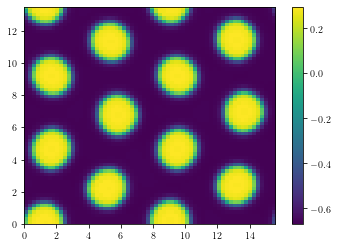

End:


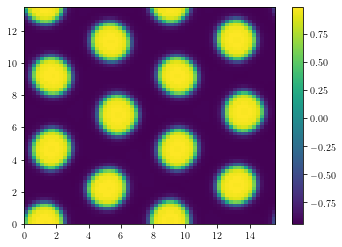


time taken: 85.984s



In [116]:
Nx = 64
Ny = 64
# Ny = 64
# Ny = int(Nx / 2 * np.sqrt(3))
# Nx = int(64/Ly * Lx)
dt = 0.0008
it = 75000

# m == ubar
m = -0.40
f = 0.3
delta = 0.15
sigma = 4./15

Lys = np.arange(15.0,18.1,0.1)
Lys = np.array([13.5])
Lxs = Lys * 2.0 / np.sqrt(3)

Ls = [[lx,ly] for lx,ly in zip(Lxs,Lys)]

for Li in Ls:
    Lx = Li[0]
    Ly = Li[1]
    rmin = Lx * np.sqrt(f) / 4.0

    print("Lx =", Lx)
    print("Ly =", Ly)

    options = {
        'Lx' : Lx,
        'Ly' : Ly,
        'Nx' : Nx,
        'Ny' : Ny,
        'delta' : delta,
        'm' : m,
        'dt' : dt,
        'it' : it,
        'prefix' : 'dft',
        'f' : f,
        'rmin' : rmin,
        'sigma' : sigma
    }

    tic = time.time()
    avgConc, energy, u = dft(options)
    toc = time.time()

    print("time taken: %.3fs" %(toc-tic))
    print("====================\n")

In [254]:
file.close()

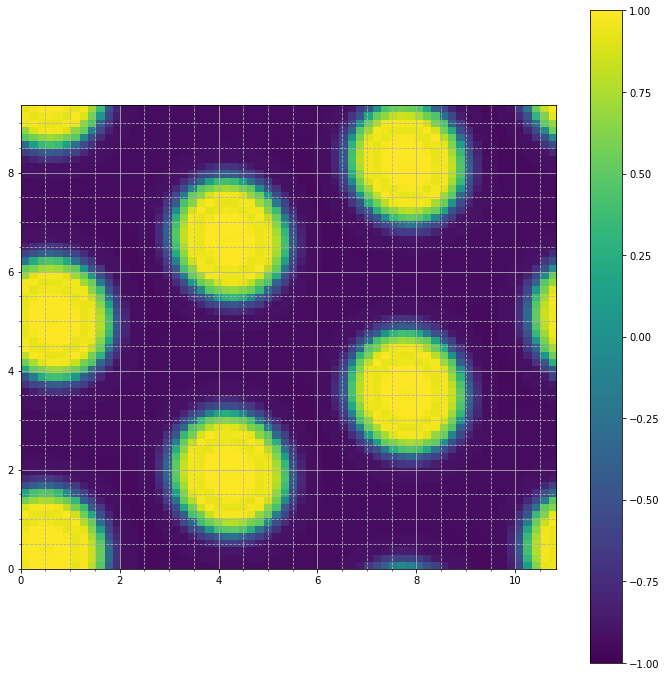

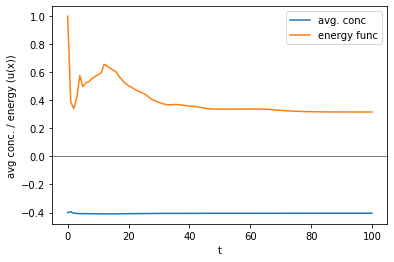

In [121]:
# plot density difference vs L.
u = u.real
fig = plt.figure(figsize=(12,12))
ax = plt.gca()
plt.imshow(u, extent=[0,Lx,0,Ly], origin='lower', vmin=-1., vmax=1.)
plt.colorbar()
plt.minorticks_on()
plt.grid(which='major',ls='-')
plt.grid(which='minor',ls='--')
plt.show()

# plot change average concentration and energy over time.
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
# ax.set_ylim([-.5,1.1])
plt.xlabel('t')
plt.ylabel('avg conc. / energy (u(x))')
plt.plot(avgConc)
plt.plot(energy)
plt.legend(['avg. conc','energy func'])
plt.axhline(y=0, linewidth=0.5, color='k')
plt.show()

[[ 0.          0.90689968  1.81379936 ... -2.72069905 -1.81379936
  -0.90689968]
 [ 1.04719755  1.95409723  2.86099692 ... -1.6735015  -0.76660181
   0.14029787]
 [ 2.0943951   3.00129478  3.90819447 ... -0.62630394  0.28059574
   1.18749542]
 ...
 [-3.14159265 -2.23469297 -1.32779329 ... -5.8622917  -4.95539202
  -4.04849234]
 [-2.0943951  -1.18749542 -0.28059574 ... -4.81509415 -3.90819447
  -3.00129478]
 [-1.04719755 -0.14029787  0.76660181 ... -3.7678966  -2.86099692
  -1.95409723]]


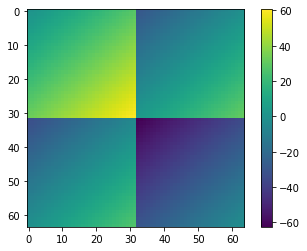

In [372]:
tpiLx = 2.*np.pi/Lx
tpiLy = 2.*np.pi/Ly

freqX = np.fft.fftfreq(Nx,(1.0/float(Nx))) * tpiLx
freqY = np.fft.fftfreq(Ny,(1.0/float(Ny))) * tpiLy

kx, ky = np.meshgrid(freqX,freqY)
k = kx + ky

print(k)

fig = plt.figure()
plt.imshow(k.real)
plt.colorbar()
plt.show()

In [117]:
def calculate(u,Lx,Ly,Nx,Ny,delta):
    u0 = u.real
    dim = 2
    m = -0.4
    
    dx = np.linspace(0,Lx,Nx)
    dy = np.linspace(0,Ly,Ny)
    dxy = [dx[1]-dx[0],dy[1]-dy[0]]
#     dxy = [dx,dy]
    
    tpiLx = 2.*np.pi/Lx
    tpiLy = 2.*np.pi/Ly
    
    freqX = np.fft.fftfreq(Nx,(1.0/float(Nx))) * tpiLx
    freqY = np.fft.fftfreq(Ny,(1.0/float(Ny))) * tpiLy
    kx, ky = np.meshgrid(freqX,freqY)
    k = kx + ky
    k2 = kx**2+ky**2
    k = k2**0.5
    k2[0,0] = 1.
    
    def padder(f):
        return np.pad(f,(2,2),mode='constant')
    
    for d in range(dim):
        dd = dxy[d]
#         u0 = integrate.trapz(u0,dd,axis=0)
        u0 = padder(u0)
        u0 = integrate.trapz(u0,dx=dd,axis=0)
    avg_conc = u0 / (Lx*Ly) * (64/66)

    T1 = np.fft.fft2(u)
#     fig = plt.figure()
#     plt.imshow(T1.real)
#     plt.colorbar()
#     plt.show()
    T1 *= -1.j * k
    T1 = np.fft.ifft2(T1)
    T1 = 0.5 * delta * (T1.real**2)

    u = u.real
    T2 = 1./(delta)*(1./4 * u**4 - 1./2 * u**2 + 1./4)

    up = u-m
    upp = np.fft.fft2(up)
#     fig = plt.figure()
#     plt.imshow(upp.real)
#     plt.colorbar()
#     plt.show()
    upp = upp / (k2**0.5)
    up = np.fft.ifft2(upp)
    
    T3 = 0.5*np.abs(up.real)**2
    
    T1l = np.copy(T1)
    T2l = np.copy(T2)
    T3l = np.copy(T3)
    for d in range(dim):
        dd = dxy[d]
        T1l = padder(T1l)
        T2l = padder(T2l)
        T3l = padder(T3l)
        T1l = integrate.trapz(T1l,dx=dd,axis=0)
        T2l = integrate.trapz(T2l,dx=dd,axis=0)
        T3l = integrate.trapz(T3l,dx=dd,axis=0)
        
#         T1l = integrate.trapz(T1l,dd,axis=0)
#         T2l = integrate.trapz(T2l,dd,axis=0)
#         T3l = integrate.trapz(T3l,dd,axis=0)
#     T3l = T3l * (Lx * Ly)

    en = T1.real + T2 + T3
#     en = np.real(en)
    for d in range(dim):
        dd = dxy[d]
        en = padder(en)
        en = integrate.trapz(en,dx=dd,axis=0)
        
    en *= (64/68)
#         en = integrate.trapz(en,dd,axis=0)
    
#     print("T1 = %.6f, T2 = %.6f, T3 = %.6f" %(T1l,T2l,T3l))
    return en, avg_conc, np.array([T1l,T2l,T3l])

Load the theoretical DFT curves (Pts1.csv and Pts2.csv). These were calculated using *Mathematica*. See lsa.nb for more details.

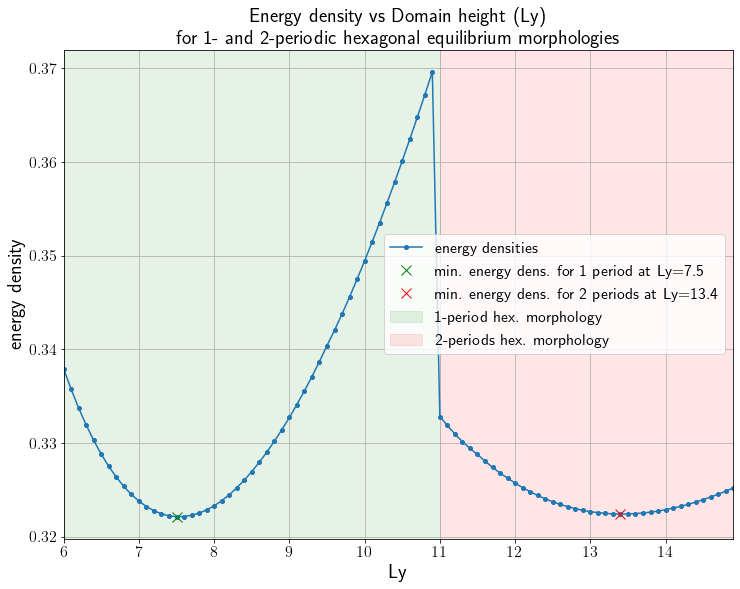

Minimum Ly = [7.5]
Maximum Ly = [10.9]
0.3221406620231314
[(6.0, 0.3379267789834081), (6.1, 0.33573416192312344), (6.199999999999999, 0.3337343344658306), (6.299999999999999, 0.33191915264962263), (6.399999999999999, 0.33028104593624374), (6.499999999999998, 0.3288129889595373), (6.599999999999998, 0.3275083616145451), (6.6999999999999975, 0.3263608318601669), (6.799999999999997, 0.3253642964870381), (6.899999999999997, 0.32451279975646574), (6.9999999999999964, 0.32380047897164654), (7.099999999999996, 0.3232216816043281), (7.199999999999996, 0.32277104110714633), (7.299999999999995, 0.32244354960936245), (7.399999999999995, 0.3222347259197987), (7.499999999999995, 0.3221406620231314), (7.599999999999994, 0.32215816962965466), (7.699999999999994, 0.3222847483477253), (7.799999999999994, 0.3225183588889847), (7.899999999999993, 0.32285717057340035), (7.999999999999993, 0.32329909378203064), (8.099999999999993, 0.32384160987437066), (8.199999999999992, 0.3244816698338875), (8.2999999999

In [135]:
# Lys = np.arange(6.91,7.10,0.01)
# print(Ly)
f = 0.3
Lys = np.arange(6.0,15.0,0.1)
# Lys = np.arange(6.1,7.0,0.1)
# Lys = np.arange(6.0,8.1,0.1)
# Lys = np.array([9.4])
# Lys = Lys = np.arange(6.15,6.26,0.01)
# Lys = np.arange(6.0,6.16,0.01)
Lxs = Lys * 2.0 / np.sqrt(3)
Nx = 64
Ny = Nx

Ls = [[lx,ly] for lx,ly in zip(Lxs,Lys)]

prefix = 'dft'
folder = 'delta=0.13_fixed_ic'
# folder = 'fixed_ic_last_working'
folder = ''
dataset = 'order_parameter'
# dataset = 'energy'
# it = 50000
it = 200000
it = 60000
delta = 0.15

dataset_name0 = "%s_%i" %(dataset,0)
dataset_name = "%s_%i" %(dataset,it)

energies = []
concs = []
rmins = Lxs * np.sqrt(f) / 4.0

for Li in Ls:
    Lx = Li[0]
    Ly = Li[1]
    
#     if Ly >= 11.1:
#         it = 100000
    
#     l = Lx/2.0
#     print(Ly)
    
    io = writer(prefix,Lx,Ly,suffix=folder)
    file = h5py.File(io.path)
#     print(io.path)
    u = file[dataset][dataset_name][...]
#     u0 = file[dataset][dataset_name0][...]
    
#     energy = file[dataset][dataset_name][...]
    energy, avg_conc, _ = calculate(u,Lx,Ly,Nx,Ny,delta)
#     energy0, _ = calculate(u0,Lx,Ly,Nx,Ny)
#     energy /= energy0
#     energy /= (2. * np.sqrt(3) * l**2)
    energy /= (Lx * Ly)
#     energy /= file[dataset][dataset_name0][...]
    energies.append(np.array(energy))
    concs.append(avg_conc)
    
    file.close()

energies = np.array(energies)

energy_min = energies.min()
Lys_min = Lys[np.where(energies==energies.min())]

energy_max = energies.max()
Lys_max = Lys[np.where(energies==energies.max())]


fig = plt.figure(figsize=(12,9))
ax = plt.gca()
plt.plot(Lys,energies, 'o-', ms='4', label="energy densities")
plt.plot(7.5,0.3221406620231314, 'gx', ms='10', label="min. energy dens. for 1 period at Ly=%.1f" %7.5)
# plt.plot(Lys_min,energy_min, 'rx', ms='10', label="min. energy dens. for 1 periods at Ly=%.1f" %Lys_min)
plt.plot(13.4, 0.32242335229037317, 'rx', ms='10', label="min. energy dens. for 2 periods at Ly=%.1f" %(13.4))

# plt.plot(Lys_max,energy_max, 'gx', label="max. rel. energy at Ly=%.1f" %Lys_max)

plt.axvspan(5., 11.0, color='g', alpha=0.1, label='1-period hex. morphology')
plt.axvspan(11.0,19.5, color='r', alpha=0.1, label='2-periods hex. morphology')

# plt.axhline(y = 0.33165732, c='g', lw=0.8, label=r'1-period min. $\approx$ 0.3317')
# plt.axhline(y = energies.min(), c='r', lw=0.8, label=r'2-period min. $\approx$ 0.3256')

# plt.axvline(x = 13.5, c='k', lw=0.8, label="anomaly at Ly=17.7")

plt.ylabel("energy density", fontsize=20)
plt.xlabel("Ly", fontsize=20)
plt.xlim([Lys[0],Lys[-1]])
plt.legend(fontsize=16)
ax.tick_params(labelsize=16)
plt.grid()
plt.title("Energy density vs Domain height (Ly)\nfor 1- and 2-periodic hexagonal equilibrium morphologies", fontsize=20)
plt.show()

# print(energies)
print("Minimum Ly =", Lys[np.where(energies==energies.min())])
print("Maximum Ly =", Lys[np.where(energies==energies.max())])
print(energies.min())
# print(np.isclose(Lys,[16.5]) * energies)
# print(concs)
print(list(zip(Lys,energies)))
# print(Lys[np.where(energies==0.24413937)])

Lx = 10.392304845413264
Ly = 9.0
shift 0
-------------
terms = [2.04808089e-12 1.83676453e+01 1.30699703e+01]
energy = 29.588341355195052
concentration = -0.39420820952193153


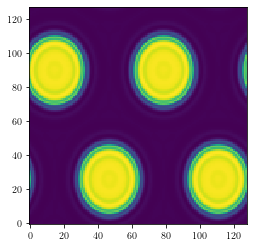

shift 1
-------------
terms = [4.12453752e-12 1.83676434e+01 1.30699708e+01]
energy = 29.58834178550433
concentration = -0.3942081699723649


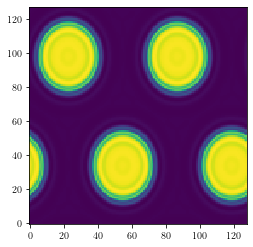

shift 2
-------------
terms = [2.04946542e-12 1.83676453e+01 1.30699707e+01]
energy = 29.588341698521948
concentration = -0.39420824907149815


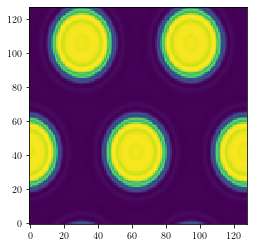

shift 3
-------------
terms = [4.09161463e-12 1.83676453e+01 1.30699702e+01]
energy = 29.588341304178194
concentration = -0.39420820952193153


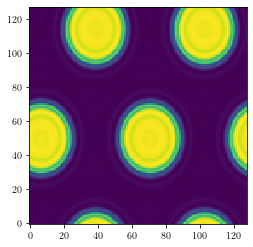

shift 4
-------------
terms = [2.04808089e-12 1.83676453e+01 1.30699703e+01]
energy = 29.588341355195052
concentration = -0.39420820952193153


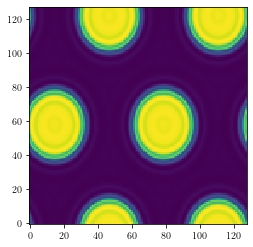

shift 5
-------------
terms = [4.12453752e-12 1.83676434e+01 1.30699708e+01]
energy = 29.588341785504326
concentration = -0.39420824907149815


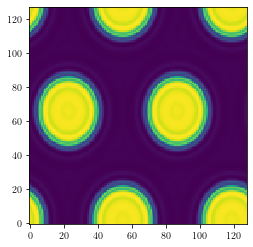

shift 6
-------------
terms = [2.04946542e-12 1.83676453e+01 1.30699707e+01]
energy = 29.58834169852194
concentration = -0.39420824907149815


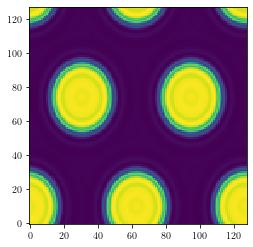

shift 7
-------------
terms = [4.09161507e-12 1.83676453e+01 1.30699702e+01]
energy = 29.588341304178194
concentration = -0.39420824907149815


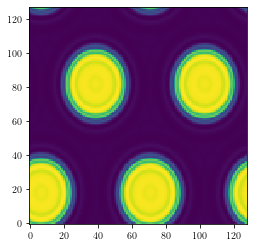

shift 8
-------------
terms = [2.04808089e-12 1.83676453e+01 1.30699703e+01]
energy = 29.58834135519505
concentration = -0.39420820952193153


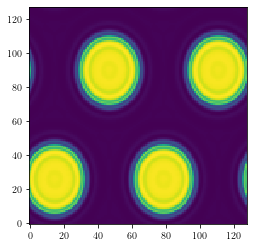

shift 9
-------------
terms = [4.12453752e-12 1.83676434e+01 1.30699708e+01]
energy = 29.58834178550433
concentration = -0.3942081699723649


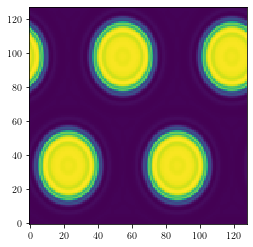

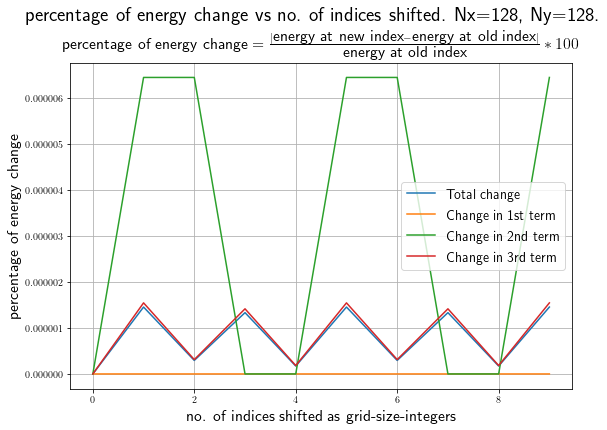

R = 3.1251002491510596


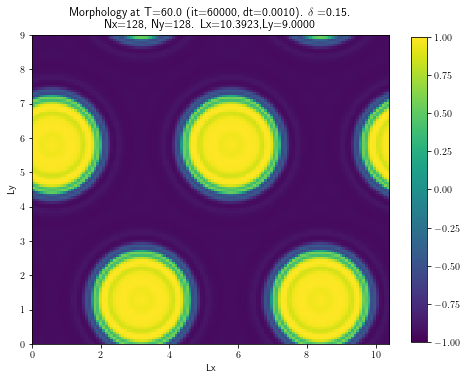

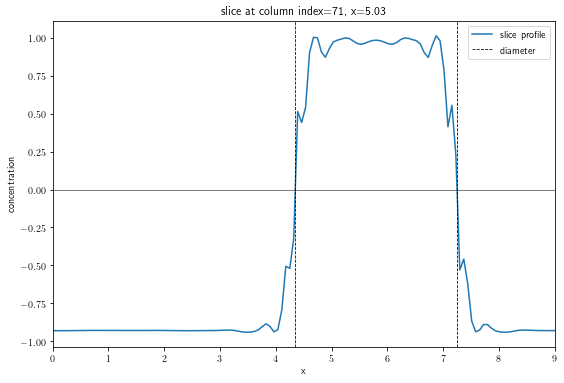

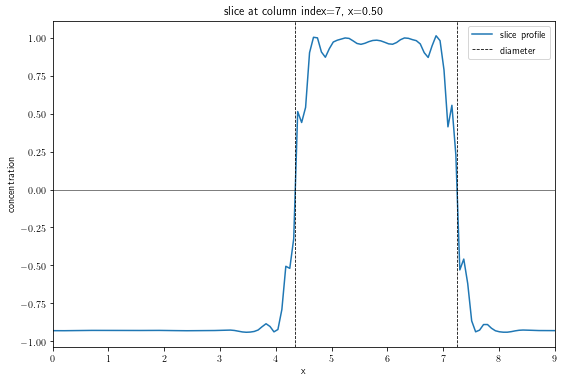

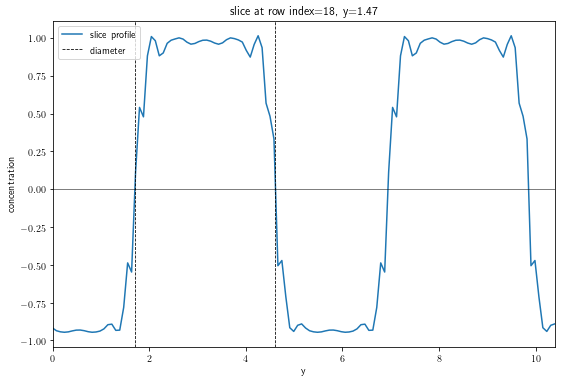

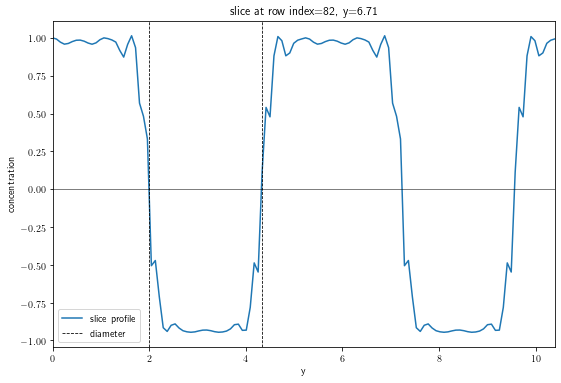

1.3792917006756198


In [140]:
Ly = 9.0
Lx = Ly * 2.0 / np.sqrt(3)
print("Lx =", Lx)
print("Ly =", Ly)

dataset = 'order_parameter'
# folder = 'delta=0.15'
it = 100000
it = 60000
dt = 0.001
delta = 0.15
folder = '128_128_fixed_ic'
# folder = ''
dataset_it = '%s_%i' %(dataset,it)
Nx = 128
Ny = Nx
delta = 0.15

io = writer(prefix,Lx,Ly,suffix=folder)
file = h5py.File(io.path)

u = file[dataset][dataset_it][:,:]
# print(file['energy']['energy_%i' %it][...] / file['energy']['energy_0'][...])
u0 = np.copy(u)

pchange, t1pc, t2pc, t3pc = [], [], [], []

def pdiff(curr,old,en_old):
    return np.abs(curr - old) / en_old * 100.

for ii in range(10):
    print("shift %i" %ii)
    print("-------------")
    
    u = np.roll(u, 8 ,axis=0)
    u = np.roll(u, 8 ,axis=1)
    en, conc, Ts = calculate(u,Lx,Ly,Nx,Ny,delta)
    
    print("terms =", Ts)
    print("energy =", en)
    print("concentration =", conc)
    
    if ii == 0: en_old = en
    if ii == 0: t1_old, t2_old, t3_old = Ts[0], Ts[1], Ts[2]
    
    t1pc.append(pdiff(Ts[0],t1_old,en_old))
    t2pc.append(pdiff(Ts[1],t2_old,en_old))
    t3pc.append(pdiff(Ts[2],t3_old,en_old))
    pchange.append(pdiff(en,en_old,en_old))
    en_old, t1_old, t2_old, t3_old = np.copy(en), Ts[0], Ts[1], Ts[2]
    
    fig = plt.figure()
    plt.imshow(u, origin="lower")
    plt.show()
    
# output = h5py.File('ic_test.h5')
# output.create_dataset('/ic', data=u.real , dtype=np.float32)
# output.close()
    
from matplotlib import rc
rc('text', usetex=True)
fig = plt.figure(figsize=(9,6))
plt.plot(pchange, label="Total change")
plt.plot(t1pc, label="Change in 1st term")
plt.plot(t2pc, label="Change in 2nd term")
plt.plot(t3pc, label="Change in 3rd term")
plt.grid()
plt.legend(fontsize=14)
plt.xlabel("no. of indices shifted as grid-size-integers", fontsize='16')
plt.ylabel("percentage of energy change", fontsize='16')
# plt.title(r'$\text{percentage of energy change} =$')
# plt.title(r'$\frac{\lvert \\text{energy at new index} - \\text{energy at old index} \rvert}{\\text{energy at old index}}$')
# plt.title(r'$\vert \frac{\textmd{sigma  text}}{\textmd{sigma}} \vert$')
plt.suptitle(r'percentage of energy change vs no. of indices shifted. Nx=%i, Ny=%i.' %(Nx,Ny), fontsize='20', y=1.01)
plt.title(r'$\textmd{percentage of energy change} = \frac{\vert \textmd{energy at new index} - \textmd{energy at old index} \vert}{\textmd{energy at old index}} * 100$', fontsize='16')
plt.show()

u = u0

lx = np.linspace(0,Lx,Nx)
ly = np.linspace(0,Ly,Ny)

curr = -np.inf
cnt = 0
curr_idx = -np.inf
idxs = []
for row in u.T:
    if row.sum() > curr:
        curr = row.sum()
        curr_idx = cnt
    cnt += 1
    
weights_x = u.sum(axis=0)
weights_x_idx = np.argsort(weights_x)
weights_x = np.sort(weights_x)[::-1]
weights_x_idx = weights_x_idx[::-1]

weights_y = u.sum(axis=1)
weights_y_idx = np.argsort(weights_y)
weights_y = np.sort(weights_y)[::-1]
weights_y_idx = weights_y_idx[::-1]

# print(weights_x_idx)
# print(weights_y_idx)

x1 = 9
x2 = 0
# x1 = np.where(weights_x_idx == 14)
# x2 = np.where(weights_x_idx == 46)
y1 = 3
y2 = 1
    
f = 0.3
sigma = 4./15
sigma = 2./(3*np.sqrt(2))
rmin = ( (16. * sigma) / (f - np.log(f)) )**(1/3)
R = rmin / np.sqrt(f)
print("R =", R)

fig = plt.figure(figsize=(8,8))
ax = plt.gca()
plt.imshow(u, extent=[0,Lx,0,Ly], origin='lower', vmin=-1., vmax=1.)
# plt.imshow(u.T)
plt.colorbar(shrink=.7)
# plt.minorticks_on()
# plt.grid(which='major',ls='-')
# plt.grid(which='minor',ls='--')
plt.xlabel("Lx")
plt.ylabel("Ly")
# plt.axvline(x=lx[curr_idx],c='r',lw=1.0,ls='--',label='slice location')
# plt.axvline(x=lx[weights_x_idx[x1]],c='r',lw=1.0,ls='--',label='slices with max. diameter of 1st ball')
# plt.axvline(x=lx[weights_x_idx[x2]],c='k',lw=1.0,ls='--',label='slices with max. diameter of 2nd ball')

# plt.axhline(y=ly[weights_y_idx[y1]],c='r',lw=1.0,ls='--')
# plt.axhline(y=ly[weights_y_idx[y2]],c='k',lw=1.0,ls='--')
# circle0 = plt.Circle((lx[weights_x_idx[x1]],ly[weights_y_idx[y1]]),R, fill=False, color='white', label='radius R')
# circle1 = plt.Circle((lx[weights_x_idx[x2]],ly[weights_y_idx[y2]]),R, fill=False, color='white')
# ax.add_patch(circle0)
# ax.add_artist(circle1)
# ax.legend([circle0], ['radius R'])

plt.title("Morphology at T=%.1f (it=%i, dt=%.4f). $\delta=$%.2f.\nNx=%i, Ny=%i. Lx=%.4f,Ly=%.4f" %(it*dt,it,dt,delta,Nx,Ny,Lx,Ly))
# plt.legend()
plt.show()

# print(lx[weights_x_idx[x1]],ly[weights_y_idx[y1]])
# print(lx[weights_x_idx[x2]],ly[weights_y_idx[y2]])

# print( ((lx[weights_x_idx[x1]] - lx[weights_x_idx[x2]])**2 + (ly[weights_y_idx[y1]] - ly[weights_y_idx[y2]])**2)**0.5)

from scipy import interpolate
def get_radius(u,idx,l,L,axs):
    if axs=='x':
        slc = u.T[idx]
        txt = 'column'
    elif axs=='y':
        slc = u[idx]
        txt = 'row'
    else:
        assert(0)
        
    tck = interpolate.splrep(l, slc, s=0)
    ls = interpolate.sproot(tck)
    length = min(ls[1] - ls[0], ls[0] + (L - ls[1]))
    
    plt.figure(figsize=(9,6))
    plt.plot(l,slc,label='slice profile')
    plt.axhline(y=0,ls='-',lw=0.5,c='k')
    plt.title("slice at %s index=%i, %s=%.2f" %(txt,idx,axs,l[idx]))
    plt.ylabel("concentration")
    plt.xlabel("%s" %axs)
    plt.axvline(x=ls[0], lw=0.8, ls='dashed', c='k', label='diameter')
    plt.axvline(x=ls[1], lw=0.8, ls='dashed', c='k')#, label='right diameter')
    plt.xlim([0,L])
    plt.legend()
    plt.show()
    return length / 2, ls
    
# print(x1[0][0])
r1,ls1 = get_radius(u,weights_x_idx[0],ly,Ly,'x')
r2,ls2 = get_radius(u,weights_x_idx[1],ly,Ly,'x')
r3,ls3 = get_radius(u,weights_y_idx[0],lx,Lx,'y')
r4,ls4 = get_radius(u,weights_y_idx[1],lx,Lx,'y')

# print([r1,r2,r3,r4])
print(np.mean([r1,r2,r3,r4]))

file.close()

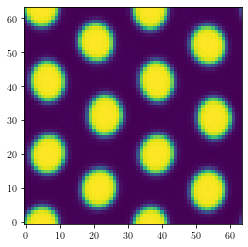

In [126]:
file = h5py.File('/home/ray/git-projects/modified_ch/ic_2periods_nospacing.h5', 'r+')
u = file['ic'][:,:]


plt.figure()
# u = np.roll(u,16,axis=0)
plt.imshow(u, origin="lower")
plt.show()

# file.create_dataset('/ic_rolled', data=u , dtype=np.float32)

file.close()

In [547]:
file.close()